In [ ]:
# @title Install dependencies
# !pip install umap-learn --quiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn as sk
from sklearn import linear_model

C:\Users\Facundo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ReLU
# from keras.layers.advanced_activations import Tanh
import tensorflow as tf
import keras

In [3]:
import seaborn as sns
import random

In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

##### Import Data

In [5]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [6]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


##### Z-score

In [7]:
# @title take PCA after preparing data by z-score
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)

In [8]:
pca_model = PCA(n_components=500)
pca_zscore = pca_model.fit_transform(Z.T)

##### Custom functions

In [9]:
def create_custom_model(input_dim, output_dim, nodes, name='model',activation = ['relu'],activation_out='linear'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        if len(nodes)==0:
            model.add(Dense(output_dim, input_dim=input_dim, activation=activation[0]))
        else:
            model.add(Dense(nodes[0], input_dim=input_dim, activation=activation[0]))
            for i in range(1,len(nodes)):
                model.add(Dense(nodes[i], input_dim=nodes[i-1], activation=activation[i]))
            model.add(Dense(output_dim, activation=activation_out))

        # Compile model
        model.compile(loss='mse',   optimizer='adam')#,   metrics=['mse'])
        return model
    return create_model

In [10]:
def split_dataset(Xdata,Ydata,trials,i,T):
    L = Xdata.shape[0]
    i_0 = i*round(L/trials)
    i_f = i_0 + L-T
    X_tr, X_tst = np.zeros((L-T,Xdata.shape[1])), np.zeros((T,Xdata.shape[1]))
    y_tr, y_tst = np.zeros((L-T,1)), np.zeros((T,1))

    if i_f>L:
        X_tr[0:i_f-L] = Xdata[0:i_f-L]
        X_tr[i_f-L:] = Xdata[i_0:]
        X_tst = Xdata[i_f-L:i_0]
        y_tr[0:i_f-L] = Ydata[0:i_f-L]
        y_tr[i_f-L:] = Ydata[i_0:]
        y_tst = Ydata[i_f-L:i_0]
    elif i_f+T == L:
        X_tr = Xdata[i_0:i_f]
        X_tst = Xdata[i_f:]
        y_tr = Ydata[i_0:i_f]
        y_tst = Ydata[i_f:]
    else:
        X_tr = Xdata[i_0:i_f]
        X_tst[:L-i_f] = Xdata[i_f:]
        X_tst[L-i_f:] = Xdata[:i_0]
        y_tr = Ydata[i_0:i_f]
        y_tst[:L-i_f] = Ydata[i_f:]
        y_tst[L-i_f:] = Ydata[:i_0]

    return X_tr, X_tst, y_tr, y_tst

In [11]:
pupArea = dat['pupilArea']
neurDat = pca_zscore.T

In [12]:
n_epochs = 100
batch_size = 15

batch_size_cnn = 64
epochs_cnn = 20
num_output_cnn = 1

## All Neurons Decoding

In [14]:
trained_ffnn_models = []
trained_glm_models = []
trained_ffnn_original_models = []
MSE_models_ffnn, MSE_models_glm, MSE_models_ffnn_original = [], [], []
R2_models_ffnn, R2_models_glm, R2_models_ffnn_original = [], [], []
predictions_ffnn, predictions_glm, predictions_ffnn_original = [], [], []
T = round(len(pupArea)*0.25)
trials = 15
L = neurDat.shape[1]
for i in range(trials):
  
    X_train, X_test, y_train, y_test = split_dataset(neurDat.T,pupArea,trials,i,T)

  # New Model
    model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf'+str(i).zfill(len(str(trials))),activation = ['relu','tanh'])
    model = model_tf()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
    model.fit(X_train,y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test),callbacks=[callback])
    trained_ffnn_models.append(model)

    y_pred = model.predict(X_test)
    predictions_ffnn.append([y_pred,y_test,X_test])
    R2_models_ffnn.append(sk.metrics.r2_score(y_test,y_pred))
    MSE_models_ffnn.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))

  #Original Model
#     model_tf_ORIGINAL = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf'+str(i).zfill(len(str(trials))),activation = ['relu','tanh'])
#     model_ORIGINAL = model_tf_ORIGINAL()
#     callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
#     model_ORIGINAL.fit(X_train,y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test),callbacks=[callback])
#     trained_ffnn_original_models.append(model)

#     y_pred = model_ORIGINAL.predict(X_test)
#     predictions_ffnn_original.append([y_pred,y_test,X_test])
#     R2_models_ffnn_original.append(sk.metrics.r2_score(y_test,y_pred))
#     MSE_models_ffnn_original.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))

  #GLM Model
    model_glm = linear_model.LinearRegression()
    model_glm.fit(X_train,y_train)

    y_pred_glm = model_glm.predict(X_test)
    predictions_glm.append([y_pred_glm,y_test,X_test])
    R2_models_glm.append(sk.metrics.r2_score(y_test,y_pred_glm))
    MSE_models_glm.append(sk.metrics.mean_squared_error(y_test,y_pred_glm,squared=False))


Epoch 1/100
351/351 [==============================] - 27s 5ms/step - loss: 726540.5000 - val_loss: 1376801.1250
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 670348.6250 - val_loss: 1300324.8750
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 620149.5000 - val_loss: 1228407.2500
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 573436.1250 - val_loss: 1160279.3750
Epoch 5/100
351/351 [==============================] - 1s 2ms/step - loss: 529811.0625 - val_loss: 1095403.2500
Epoch 6/100
351/351 [==============================] - 1s 2ms/step - loss: 489064.7500 - val_loss: 1033768.7500
Epoch 7/100
351/351 [==============================] - 1s 2ms/step - loss: 451046.7500 - val_loss: 975134.1875
Epoch 8/100
351/351 [==============================] - 1s 2ms/step - loss: 415543.5000 - val_loss: 919288.6250
Epoch 9/100
351/351 [==============================] - 1s 2ms/step - loss: 382451.5312 - val_loss: 866098

351/351 [==============================] - 1s 2ms/step - loss: 1456.5312 - val_loss: 43299.4102
Epoch 76/100
351/351 [==============================] - 1s 2ms/step - loss: 1412.2622 - val_loss: 45528.1445
Epoch 77/100
351/351 [==============================] - 1s 2ms/step - loss: 1382.4031 - val_loss: 45124.9961
Epoch 78/100
351/351 [==============================] - 1s 2ms/step - loss: 1290.3687 - val_loss: 44923.8164
Epoch 79/100
351/351 [==============================] - 1s 2ms/step - loss: 1249.6764 - val_loss: 44313.6406
Epoch 1/100
351/351 [==============================] - 1s 2ms/step - loss: 774451.6250 - val_loss: 1247800.3750
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 716285.6875 - val_loss: 1176016.0000
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 664201.1250 - val_loss: 1108674.5000
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 615631.3750 - val_loss: 1044903.8750
Epoch 5/100
351/351 

351/351 [==============================] - 1s 2ms/step - loss: 1692.7291 - val_loss: 38231.2812
Epoch 71/100
351/351 [==============================] - 1s 2ms/step - loss: 1576.7915 - val_loss: 39077.5547
Epoch 72/100
351/351 [==============================] - 1s 2ms/step - loss: 1528.6987 - val_loss: 36972.4141
Epoch 73/100
351/351 [==============================] - 1s 2ms/step - loss: 1464.2179 - val_loss: 38406.0391
Epoch 74/100
351/351 [==============================] - 1s 2ms/step - loss: 1430.3722 - val_loss: 38070.8086
Epoch 75/100
351/351 [==============================] - 1s 2ms/step - loss: 1362.0266 - val_loss: 38383.2812
Epoch 76/100
351/351 [==============================] - 1s 2ms/step - loss: 1287.8636 - val_loss: 38072.7305
Epoch 1/100
351/351 [==============================] - 1s 2ms/step - loss: 832809.9375 - val_loss: 1067454.0000
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 773021.3125 - val_loss: 1001383.5000
Epoch 3/100
351/351 [=====

351/351 [==============================] - 1s 2ms/step - loss: 2566.1765 - val_loss: 30662.1055
Epoch 69/100
351/351 [==============================] - 1s 2ms/step - loss: 2466.9548 - val_loss: 30489.0527
Epoch 70/100
351/351 [==============================] - 1s 2ms/step - loss: 2277.2556 - val_loss: 30371.4238
Epoch 71/100
351/351 [==============================] - 1s 2ms/step - loss: 2156.2559 - val_loss: 29801.6895
Epoch 72/100
351/351 [==============================] - 1s 2ms/step - loss: 2068.6577 - val_loss: 29459.8125
Epoch 73/100
351/351 [==============================] - 1s 2ms/step - loss: 1981.6636 - val_loss: 30154.8535
Epoch 74/100
351/351 [==============================] - 1s 2ms/step - loss: 1916.3896 - val_loss: 29806.7480
Epoch 75/100
351/351 [==============================] - 1s 2ms/step - loss: 1828.8723 - val_loss: 29856.2852
Epoch 76/100
351/351 [==============================] - 1s 2ms/step - loss: 1771.8884 - val_loss: 30067.9648
Epoch 1/100
351/351 [===========

351/351 [==============================] - 1s 2ms/step - loss: 4298.4810 - val_loss: 19311.6035
Epoch 67/100
351/351 [==============================] - 1s 2ms/step - loss: 4029.8020 - val_loss: 19248.5078
Epoch 68/100
351/351 [==============================] - 1s 2ms/step - loss: 3804.2112 - val_loss: 18789.1582
Epoch 69/100
351/351 [==============================] - 1s 2ms/step - loss: 3590.2485 - val_loss: 18671.4648
Epoch 70/100
351/351 [==============================] - 1s 2ms/step - loss: 3382.3530 - val_loss: 18460.3008
Epoch 71/100
351/351 [==============================] - 1s 2ms/step - loss: 3245.3389 - val_loss: 17966.6074
Epoch 72/100
351/351 [==============================] - 1s 2ms/step - loss: 3084.6323 - val_loss: 18355.2617
Epoch 73/100
351/351 [==============================] - 1s 2ms/step - loss: 3025.1929 - val_loss: 17526.9355
Epoch 74/100
351/351 [==============================] - 1s 2ms/step - loss: 2912.2231 - val_loss: 17956.6152
Epoch 75/100
351/351 [==========

351/351 [==============================] - 1s 2ms/step - loss: 259613.3906 - val_loss: 144844.0469
Epoch 20/100
351/351 [==============================] - 1s 2ms/step - loss: 240062.9844 - val_loss: 130153.8672
Epoch 21/100
351/351 [==============================] - 1s 2ms/step - loss: 221933.4531 - val_loss: 116929.5703
Epoch 22/100
351/351 [==============================] - 1s 2ms/step - loss: 205137.8438 - val_loss: 104782.1484
Epoch 23/100
351/351 [==============================] - 1s 2ms/step - loss: 189450.1562 - val_loss: 93995.2734
Epoch 24/100
351/351 [==============================] - 1s 2ms/step - loss: 174917.2344 - val_loss: 84253.0078
Epoch 25/100
351/351 [==============================] - 1s 2ms/step - loss: 161432.8594 - val_loss: 75728.0312
Epoch 26/100
351/351 [==============================] - 1s 2ms/step - loss: 148968.4062 - val_loss: 67888.9531
Epoch 27/100
351/351 [==============================] - 1s 2ms/step - loss: 137353.1719 - val_loss: 60770.7695
Epoch 28/1

351/351 [==============================] - 1s 2ms/step - loss: 44501.2539 - val_loss: 16699.1504
Epoch 41/100
351/351 [==============================] - 1s 2ms/step - loss: 40411.4688 - val_loss: 15587.1699
Epoch 42/100
351/351 [==============================] - 1s 2ms/step - loss: 36727.0898 - val_loss: 14522.2676
Epoch 43/100
351/351 [==============================] - 1s 2ms/step - loss: 33336.2812 - val_loss: 13946.7539
Epoch 44/100
351/351 [==============================] - 1s 2ms/step - loss: 30195.2773 - val_loss: 13208.9648
Epoch 45/100
351/351 [==============================] - 1s 2ms/step - loss: 27252.8477 - val_loss: 12769.5557
Epoch 46/100
351/351 [==============================] - 1s 2ms/step - loss: 24632.3047 - val_loss: 12331.7090
Epoch 47/100
351/351 [==============================] - 1s 2ms/step - loss: 22263.5586 - val_loss: 12285.7148
Epoch 48/100
351/351 [==============================] - 1s 2ms/step - loss: 20050.4961 - val_loss: 11915.4775
Epoch 49/100
351/351 [=

351/351 [==============================] - 1s 2ms/step - loss: 477589.7500 - val_loss: 161691.0938
Epoch 13/100
351/351 [==============================] - 1s 2ms/step - loss: 441928.0625 - val_loss: 148326.2344
Epoch 14/100
351/351 [==============================] - 1s 2ms/step - loss: 408463.8438 - val_loss: 136909.8438
Epoch 15/100
351/351 [==============================] - 1s 2ms/step - loss: 377130.8438 - val_loss: 127411.7969
Epoch 16/100
351/351 [==============================] - 1s 2ms/step - loss: 347878.8750 - val_loss: 119744.0000
Epoch 17/100
351/351 [==============================] - 1s 2ms/step - loss: 320729.3125 - val_loss: 113909.5000
Epoch 18/100
351/351 [==============================] - 1s 2ms/step - loss: 295621.0625 - val_loss: 109805.8594
Epoch 19/100
351/351 [==============================] - 1s 2ms/step - loss: 272469.4062 - val_loss: 107363.9062
Epoch 20/100
351/351 [==============================] - 1s 2ms/step - loss: 251241.7031 - val_loss: 105886.5156
Epoch

Epoch 35/100
351/351 [==============================] - 1s 2ms/step - loss: 67297.9375 - val_loss: 50593.6250
Epoch 36/100
351/351 [==============================] - 1s 2ms/step - loss: 61415.2812 - val_loss: 49861.1992
Epoch 37/100
351/351 [==============================] - 1s 2ms/step - loss: 56010.2539 - val_loss: 47114.1836
Epoch 38/100
351/351 [==============================] - 1s 2ms/step - loss: 51071.8789 - val_loss: 45858.1719
Epoch 39/100
351/351 [==============================] - 1s 2ms/step - loss: 46275.2773 - val_loss: 44475.4102
Epoch 40/100
351/351 [==============================] - 1s 2ms/step - loss: 41940.3086 - val_loss: 45590.1836
Epoch 41/100
351/351 [==============================] - 1s 2ms/step - loss: 38006.3516 - val_loss: 44570.4531
Epoch 42/100
351/351 [==============================] - 1s 2ms/step - loss: 34425.5391 - val_loss: 44025.4531
Epoch 43/100
351/351 [==============================] - 1s 2ms/step - loss: 31199.3008 - val_loss: 43544.7344
Epoch 44/1

351/351 [==============================] - 1s 2ms/step - loss: 11772.7031 - val_loss: 22529.0723
Epoch 54/100
351/351 [==============================] - 1s 2ms/step - loss: 10800.4150 - val_loss: 22430.4609
Epoch 55/100
351/351 [==============================] - 1s 2ms/step - loss: 9808.2871 - val_loss: 21790.7051
Epoch 56/100
351/351 [==============================] - 1s 2ms/step - loss: 8978.2676 - val_loss: 21332.1543
Epoch 57/100
351/351 [==============================] - 1s 2ms/step - loss: 8158.0820 - val_loss: 20203.7852
Epoch 58/100
351/351 [==============================] - 1s 2ms/step - loss: 7452.3843 - val_loss: 21561.8281
Epoch 59/100
351/351 [==============================] - 1s 2ms/step - loss: 6842.0972 - val_loss: 20360.0039
Epoch 60/100
351/351 [==============================] - 1s 2ms/step - loss: 6292.7388 - val_loss: 19842.7070
Epoch 61/100
351/351 [==============================] - 1s 2ms/step - loss: 5849.7280 - val_loss: 20071.3574
Epoch 62/100
351/351 [========

351/351 [==============================] - 1s 2ms/step - loss: 5198.8389 - val_loss: 16237.8428
Epoch 64/100
351/351 [==============================] - 1s 2ms/step - loss: 4879.5059 - val_loss: 15914.5977
Epoch 1/100
351/351 [==============================] - 1s 2ms/step - loss: 857875.1875 - val_loss: 995558.6875
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 797941.2500 - val_loss: 931305.2500
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 743608.2500 - val_loss: 871074.4375
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 692757.6875 - val_loss: 814283.0625
Epoch 5/100
351/351 [==============================] - 1s 2ms/step - loss: 645039.5625 - val_loss: 760592.3750
Epoch 6/100
351/351 [==============================] - 1s 2ms/step - loss: 600178.5000 - val_loss: 709737.8125
Epoch 7/100
351/351 [==============================] - 1s 2ms/step - loss: 558063.5625 - val_loss: 661757.0625
Epoch 8/100
351/35

351/351 [==============================] - 1s 2ms/step - loss: 753251.3750 - val_loss: 1064218.2500
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 700388.9375 - val_loss: 999441.3750
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 651124.6875 - val_loss: 938206.3125
Epoch 5/100
351/351 [==============================] - 1s 2ms/step - loss: 605004.6250 - val_loss: 880315.5000
Epoch 6/100
351/351 [==============================] - 1s 2ms/step - loss: 561735.3125 - val_loss: 825437.9375
Epoch 7/100
351/351 [==============================] - 1s 2ms/step - loss: 521139.2500 - val_loss: 773200.2500
Epoch 8/100
351/351 [==============================] - 1s 2ms/step - loss: 483096.3125 - val_loss: 723694.6875
Epoch 9/100
351/351 [==============================] - 1s 2ms/step - loss: 447514.6875 - val_loss: 676747.8125
Epoch 10/100
351/351 [==============================] - 1s 2ms/step - loss: 414283.3750 - val_loss: 632351.6875
Epoch 11/10

351/351 [==============================] - 1s 2ms/step - loss: 2552.6606 - val_loss: 18723.5215
Epoch 77/100
351/351 [==============================] - 1s 2ms/step - loss: 2445.9565 - val_loss: 19110.9102
Epoch 78/100
351/351 [==============================] - 1s 2ms/step - loss: 2328.8333 - val_loss: 19149.7852
Epoch 79/100
351/351 [==============================] - 1s 2ms/step - loss: 2278.8882 - val_loss: 18946.6172
Epoch 1/100
351/351 [==============================] - 1s 2ms/step - loss: 750914.1875 - val_loss: 1313582.0000
Epoch 2/100
351/351 [==============================] - 1s 2ms/step - loss: 693887.6875 - val_loss: 1238752.3750
Epoch 3/100
351/351 [==============================] - 1s 2ms/step - loss: 642957.3125 - val_loss: 1168374.8750
Epoch 4/100
351/351 [==============================] - 1s 2ms/step - loss: 595559.8750 - val_loss: 1101941.8750
Epoch 5/100
351/351 [==============================] - 1s 2ms/step - loss: 551292.3750 - val_loss: 1038772.5625
Epoch 6/100
351/3

351/351 [==============================] - 1s 2ms/step - loss: 2150.6970 - val_loss: 30561.1387
Epoch 72/100
351/351 [==============================] - 1s 2ms/step - loss: 2043.2209 - val_loss: 30012.1777
Epoch 73/100
351/351 [==============================] - 1s 2ms/step - loss: 1968.7644 - val_loss: 29405.0703
Epoch 74/100
351/351 [==============================] - 1s 2ms/step - loss: 1836.5602 - val_loss: 29575.9219
Epoch 75/100
351/351 [==============================] - 1s 2ms/step - loss: 1735.3412 - val_loss: 28659.6914
Epoch 76/100
351/351 [==============================] - 1s 2ms/step - loss: 1658.8541 - val_loss: 29735.9980
Epoch 77/100
351/351 [==============================] - 1s 2ms/step - loss: 1606.7441 - val_loss: 29508.8867
Epoch 78/100
351/351 [==============================] - 1s 2ms/step - loss: 1543.3695 - val_loss: 28614.8984
Epoch 79/100
351/351 [==============================] - 1s 2ms/step - loss: 1502.2145 - val_loss: 29007.1055
Epoch 80/100
351/351 [==========

Text(0, 0.5, 'MSE')

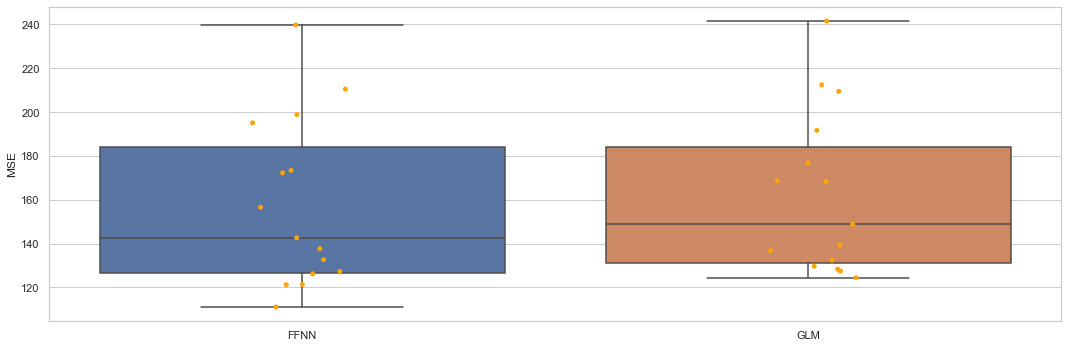

In [16]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

# ax = sns.boxplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm])
# ax = sns.stripplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm],color='orange')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['FFNN','FFNN orig','GLM'])#, minor=False, rotation=45)
ax = sns.boxplot(data=[MSE_models_ffnn,MSE_models_glm])
ax = sns.stripplot(data=[MSE_models_ffnn,MSE_models_glm],color='orange')
ax.set_xticks([0,1])
ax.set_xticklabels(['FFNN','GLM'])#, minor=False, rotation=45)
# plt.title('MSE')
plt.ylabel('MSE')

In [ ]:
print(MSE_models_ffnn)

[215.42219458348973, 194.21190692588848, 173.9282592180641, 140.5295879037159, 121.56833922180817, 119.32822963034168, 111.61586160020524, 160.2733427035106, 244.30254690221926, 203.6919467347749, 147.51031875410953, 124.27931813134656, 124.22524084905143, 135.6117090516331, 173.9098013101488]


In [ ]:
print(MSE_models_ffnn_original)

[215.05873388118897, 198.59171602137852, 170.17579619343635, 136.99485707612848, 126.70844055626324, 122.58673518496211, 112.75150427983102, 162.25948102927669, 233.7482499672927, 206.56955713535325, 139.09047806139188, 127.85992509141052, 127.31976114330583, 136.0539178445888, 175.1367117527349]


In [ ]:
print(MSE_models_glm)

[212.37339754691283, 192.87092534402797, 167.67572045121796, 139.96498503995193, 130.94684536855578, 130.1184778633433, 124.60314001861818, 178.1521346412587, 244.23933970976623, 215.02610391372986, 151.22241224749973, 130.6487780094949, 133.39558511683433, 140.53413585016924, 167.65240333034242]


Text(0, 0.5, 'R^2')

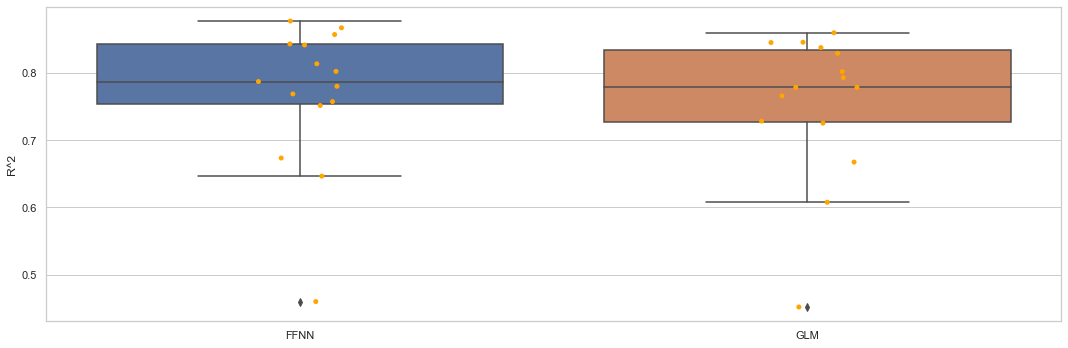

In [18]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

# ax = sns.boxplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm])
# ax = sns.stripplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm],color='orange')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['FFNN','FFNN orig','GLM'])
ax = sns.boxplot(data=[R2_models_ffnn,R2_models_glm])
ax = sns.stripplot(data=[R2_models_ffnn,R2_models_glm],color='orange')
ax.set_xticks([0,1])
ax.set_xticklabels(['FFNN','GLM'])
plt.ylabel('R^2')

In [ ]:
print(R2_models_ffnn)

[0.6579379989297456, 0.7593018093470691, 0.7783481173769217, 0.7901421935743325, 0.7496107721416152, 0.8080335911402113, 0.8751817018593884, 0.7764884025785241, 0.4400261705731888, 0.6291004008208785, 0.8316454026467334, 0.8704155097910551, 0.863119547247278, 0.8456338234789345, 0.7639070780981568]


In [ ]:
print(R2_models_ffnn_original)

[0.6590912804082611, 0.7483230873878557, 0.787809123778709, 0.8005665001151352, 0.7279894395072275, 0.7974063619712499, 0.8726288370324399, 0.7709144806228695, 0.487364736392328, 0.6185467818955817, 0.8503161389613682, 0.8628410372163632, 0.856215070584871, 0.844625453669126, 0.760564119361847]


In [ ]:
print(R2_models_glm)

[0.6675516589440477, 0.7626142479989821, 0.7939979767160193, 0.7918250889733801, 0.7094875465436983, 0.7717468423997227, 0.84444484849516, 0.7238407886120489, 0.44031589162070284, 0.5866756245486286, 0.8230655092365766, 0.8567924202916014, 0.8421645143737975, 0.8342240887282171, 0.7805910110147387]


## Layer Decoding

#### Brief summary: we will train a linear and nonlinear decoder to predict the pupil area from the first 500 PC of neural activity for each of the 9 layers.

1) We will first find the number of neurons that has the layer with the least amount of neurons (n).

2) For each layer, we run 5 trials, in which we randomly extract 0.9*n neurons from the layer and compute the first 500 PC.

3) For each trial, we train the decoders with a training set (75% of the PC time series) and validation set (remaining 25%). In order not to obtain biased results from the chosen training set, we run 5 different trials where we select different chunks of the time series as a training set (therefore, we end up with 25 different models for each layer).

#### Decoding Methods: FFNN and Linear Dec.


In [ ]:
T = round(len(pupArea)*0.25)
trials = 5
trials_neuron = 5

pca_layers_zscore = []
z_values = np.unique(dat['xyz'][-1])

minimal_neuron_count = min([len(np.where(dat['xyz'][-1] == z_values[layer])[0]) for layer in range(len(z_values))]) #number of neurons in the layer which has the least number of neurons
minimal_neuron_count = round(minimal_neuron_count*0.9) # grab 90% of this number

trained_ffnn_models = []
trained_glm_models = []
MSE_models_ffnn, MSE_models_glm =  np.zeros((len(z_values),trials_neuron,trials)), np.zeros((len(z_values),trials_neuron,trials))
R2_models_ffnn, R2_models_glm = np.zeros((len(z_values),trials_neuron,trials)), np.zeros((len(z_values),trials_neuron,trials))
predictions_ffnn, predictions_glm = [],[]
for layer in range(4,len(z_values)):

    trained_ffnn_models.append([])
    trained_glm_models.append([])
    predictions_ffnn.append([]) 
    predictions_glm.append([])

    for i in range(trials_neuron):

        pca_layer_model = PCA(n_components=500)

        index = np.where(dat['xyz'][-1] == z_values[layer])[0]
        random.shuffle(index)

        pca_layers_zscore.append(pca_model.fit_transform(Z[index[:minimal_neuron_count]].T))

        trained_ffnn_models[-1].append([])
        trained_glm_models[-1].append([])
        predictions_ffnn[-1].append([])
        predictions_glm[-1].append([])

        for j in range(trials):
    
            X_train, X_test, y_train, y_test = split_dataset(pca_layers_zscore[-1],pupArea,trials,j,T)

          # New Model
            model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf'+str(i).zfill(len(str(trials))),activation = ['relu','tanh'])
            model = model_tf()
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
            model.fit(X_train,y_train,batch_size=batch_size,epochs=n_epochs,verbose=0,validation_data=(X_test, y_test),callbacks=[callback])
            trained_ffnn_models[-1].append(model)

            y_pred = model.predict(X_test)
            predictions_ffnn[-1].append([y_pred,y_test,X_test])
            R2_models_ffnn[layer,i,j] = sk.metrics.r2_score(y_test,y_pred)
            MSE_models_ffnn[layer,i,j] = sk.metrics.mean_squared_error(y_test,y_pred,squared=False)

          #GLM Model
            model_glm = linear_model.LinearRegression()
            model_glm.fit(X_train,y_train)
            trained_glm_models[-1].append(model_glm)

            y_pred_glm = model_glm.predict(X_test)
            predictions_glm[-1].append([y_pred_glm,y_test,X_test])
            R2_models_glm[layer,i,j] = sk.metrics.r2_score(y_test,y_pred_glm)
            MSE_models_glm[layer,i,j] = sk.metrics.mean_squared_error(y_test,y_pred_glm,squared=False)
            print(layer,i,j)

#### Decoding Results

#### Data matrices

In [ ]:
MSE_models_ffnn = np.array([[[312.06224633, 222.35330975, 177.96515341, 275.01358348, 196.01606725],
  [320.20267767, 219.50326346, 174.41018601, 285.76354437, 189.16480035],
  [308.67791793, 216.76373004, 177.12005555, 291.66783101, 194.3476998 ],
  [298.05601717, 217.51869411, 182.71735424, 269.68561153, 188.70743667],
  [319.60585635, 223.93456006, 180.81353518, 283.32146661, 186.6057247 ]],
 [[296.07440918, 200.21954957, 154.36119676, 265.77888827, 167.83725158],
  [288.51389973, 203.90288569, 153.71161559, 276.78082591, 171.19554885],
  [290.96326265, 202.21655956, 154.89026265, 274.46841591, 170.73044056],
  [282.96568438, 190.22299115, 146.0053414 , 264.58339775, 164.15205463],
  [288.48452676, 198.89654021, 153.81261891, 269.73930779, 169.72676874]],
 [[281.76005575, 199.06676399, 151.12889294, 251.62152476, 166.50334547],
  [300.65162573, 203.97006323, 148.74445769, 246.67860073, 167.70610496],
  [287.74305498, 197.63648627, 151.06948972, 264.09994316, 170.32812549],
  [287.48681727, 201.92164409, 154.69604155, 251.9483848 , 169.94451625],
  [281.33858236, 201.63980284, 153.74149832, 245.85205319, 168.18345883]],
 [[292.4305419 , 204.52359282, 158.98465323, 248.29652343, 167.66698344],
  [297.16896267, 209.2637133 , 163.02442667, 272.42416909, 174.24331365],
  [293.28143695, 208.70569391, 163.7034498 , 260.51478622, 171.16333765],
  [292.98869032, 210.5591693 , 160.3123007 , 246.08454086, 170.80165784],
  [285.10149318, 204.14566475, 161.7487851 , 243.76836416, 172.19345286]],
 [[298.66073962, 204.62805858, 162.44390913, 260.56971973, 181.05854763],
  [296.41419929, 204.96832175, 166.51416171, 258.76266673, 181.78344668],
  [298.15049884, 208.46779642, 176.1011025 , 263.5771122 , 183.65779676],
  [301.56093994, 209.32257472, 163.19142898, 261.55316595, 182.87204087],
  [294.92731632, 207.33012608, 165.77967501, 255.32689504, 179.33995603]],
 [[295.00554806, 221.94965492, 160.41561721, 236.01052001, 183.08547929],
  [302.4744806 , 223.20029733, 165.33640229, 243.4728082 , 183.51520548],
  [301.31006488, 219.40469242, 166.35640407, 236.92695257, 189.45683149],
  [302.97809835, 218.66732606, 169.38169916, 236.95662571, 183.17041021],
  [300.95083655, 220.36111472, 168.91686293, 253.14239195, 182.7753959 ]],
 [[318.07010524, 232.4550324 , 179.2477446 , 259.26742963, 189.96268664],
  [319.27546523, 227.18117591, 176.65270455, 271.71649383, 194.22018055],
  [315.90733074, 230.16645497, 177.20315767, 269.26589259, 195.25812517],
  [315.43231041, 232.24230309, 179.91531052, 267.0103866 , 201.17625846],
  [325.38790987, 228.53346092, 191.38914153, 266.12634635, 196.26019573]],
 [[330.69149504, 236.31410238, 187.59233235, 278.67069944, 199.82626324],
  [341.10764484, 236.2507691 , 191.14080381, 266.87990567, 206.62596522],
  [328.99402109, 237.23705677, 189.44322986, 268.95579283, 213.3325159 ],
  [328.54303449, 238.53400284, 184.69782361, 267.48070314, 204.10311568],
  [329.83779326, 236.16225986, 190.40106889, 274.33530713, 204.88592504]],
 [[362.56319073, 255.62501886, 218.61745603, 317.84938102, 232.52529526],
  [370.01332342, 255.69295907, 220.84589425, 321.69562086, 238.46572427],
  [367.88719755, 252.74119691, 218.75819767, 304.5857758 , 237.64421805],
  [364.42730644, 254.33808965, 220.92356428, 315.50758752, 236.45752777],
  [373.86716587, 256.31525173, 223.23489633, 310.15736133, 235.89193311]]])

In [ ]:
MSE_models_glm = np.array([[[320.31033899, 230.14401122, 199.36098996, 292.8342822,  208.85278138],
  [318.0605988,  225.89621012, 199.86002116, 307.9874286 , 212.35977176],
  [319.68194918, 228.42803916, 211.00416287, 299.02569328, 207.51439317],
  [320.14596715, 222.89701866, 204.39373543, 300.38271026, 201.41211519],
  [325.46877114, 230.5803143 , 207.74557914, 307.93771736, 206.32372679]],
 [[300.64472235, 201.69781017, 183.02596257, 294.03419284, 184.83428444],
  [301.81190683, 208.62820687, 178.80455657, 304.15082682, 190.92187085],
  [293.54661175, 207.76221192, 183.00243427, 294.76814306, 190.33596563],
  [293.99544617, 196.88459241, 177.88051824, 289.72159319, 183.11056615],
  [297.96925678, 207.47075112, 179.1316593 , 293.57333921, 191.79650204]],
 [[290.12202441, 195.8124305 , 183.69326191, 268.13524766, 177.44830706],
  [296.98024541, 202.46038576, 180.74495644, 265.42683701, 177.79084055],
  [296.43043391, 198.26764511, 184.11607783, 275.09653136, 183.26590442],
  [292.0665351 , 199.97274372, 177.85163829, 269.5512622 , 178.16098863],
  [286.51349589, 198.83385423, 177.98335268, 267.54378656, 177.22319204]],
 [[298.7018719 , 208.90815811, 181.45299108, 270.83884514, 182.53483809],
  [305.84410779, 218.00386387, 192.95421716, 281.04890919, 185.37165325],
  [293.08199579, 211.49353837, 182.98798772, 264.75877881, 179.81947998],
  [292.55355495, 211.42528922, 182.22066822, 261.09089538, 181.13432583],
  [289.79279709, 211.00136956, 177.7443661 , 254.55665476, 179.74372496]],
 [[296.62252119, 199.02145488, 191.93343599, 270.01457028, 181.68412888],
  [299.586034  , 202.64881298, 189.73244063, 269.35251919, 184.86808216],
  [299.5657369 , 206.54218238, 195.68944477, 272.91741976, 184.65955034],
  [306.53843278, 208.00826887, 188.03200942, 268.87617744, 185.58727758],
  [293.79896052, 202.25062854, 184.3573222 , 267.05677835, 181.51595042]],
 [[300.12719328, 221.52246627, 187.44861539, 256.08784992, 185.01690422],
  [302.35078045, 223.44788418, 191.36533739, 263.82592144, 188.26286575],
  [299.65226609, 220.59533738, 190.43354172, 253.70996386, 189.58822396],
  [298.3728465 , 217.53672836, 190.08953079, 256.98387334, 184.61234655],
  [300.49358387, 219.13236296, 189.08154368, 262.02166534, 184.62238565]],
 [[317.80502442, 227.65645749, 213.7147677 , 271.8738338 , 194.92397092],
  [316.24776204, 226.73566529, 208.47897743, 279.18821391, 197.65818805],
  [318.45172258, 227.86258724, 211.57480382, 273.77833444, 197.98071669],
  [319.25403505, 229.57656121, 207.28718692, 280.78287899, 202.6969767 ],
  [314.85954285, 225.08767508, 209.43600584, 267.62623666, 198.9533942 ]],
 [[333.19766763, 241.76911764, 217.30238824, 298.84248176, 206.94697204],
  [333.79955565, 241.15238566, 218.16285499, 284.32126174, 209.69442507],
  [326.94879761, 240.93909677, 209.81669657, 288.46828383, 207.50568515],
  [329.34170733, 237.14741192, 210.531168  , 284.82981859, 208.25994877],
  [328.42048335, 238.35151204, 211.73291149, 289.2986278 , 208.01131808]],
 [[357.47073903, 252.32641559, 236.26034115, 310.87537905, 229.94253476],
  [358.01054779, 251.63920555, 235.85649077, 309.20871817, 228.95367286],
  [353.76128728, 248.49398372, 236.96778205, 305.38664256, 228.02227598],
  [355.81724053, 252.84076125, 238.00623115, 307.78282976, 231.82811631],
  [353.706687  , 251.38409264, 237.8313859 , 307.62422073, 227.75641282]]])

In [ ]:
R2_models_ffnn = [[[0.28219513, 0.47461608, 0.68268078, 0.32389066, 0.65919569],
  [0.24425748, 0.48799813, 0.69523147, 0.27000095, 0.68260331],
  [0.29767995, 0.50069856, 0.68568732, 0.23952365, 0.66497243],
  [0.34518333, 0.49721448, 0.66550778, 0.34983408, 0.68413626],
  [0.24707209, 0.46711704, 0.67244193, 0.28242449, 0.69113289]],
 [[0.35386141, 0.57400692, 0.76127236, 0.36853453, 0.75013901],
  [0.38643946, 0.5581892 , 0.76327736, 0.31517336, 0.74003991],
  [0.37597749, 0.56546675, 0.7596331 , 0.32656854, 0.74145053],
  [0.40981049, 0.61548295, 0.78641836, 0.3742025 , 0.76099093],
  [0.38656438, 0.57961807, 0.76296616, 0.34957515, 0.74448146]],
 [[0.41482901, 0.5788982 , 0.77116554, 0.43401591, 0.75409483],
  [0.33372878, 0.55789804, 0.77832944, 0.4560342 , 0.75052934],
  [0.38971367, 0.58492762, 0.7713454 , 0.37648736, 0.7426676 ],
  [0.39080012, 0.56673328, 0.76023553, 0.43254451, 0.74382541],
  [0.41657837, 0.56794194, 0.76318531, 0.45967343, 0.74910714]],
 [[0.36966794, 0.55549525, 0.74675736, 0.44887524, 0.75064571],
  [0.34907517, 0.53465244, 0.73372415, 0.33656265, 0.73070147],
  [0.3659944 , 0.53713091, 0.73150136, 0.39330083, 0.74013773],
  [0.36725947, 0.5288731 , 0.74251015, 0.45865104, 0.74123478],
  [0.40086744, 0.55713648, 0.73787498, 0.46879356, 0.73700045]],
 [[ 0.34252353,  0.55504105,  0.73561714, 0.39304494,  0.70922317],
  [ 0.35237747,  0.55356003,  0.72220222,  0.40143422,  0.70689016],
  [ 0.34476812,  0.53818553,  0.68929333,  0.37895362,  0.70081454],
  [ 0.32969244,  0.53439062,  0.73317832,  0.38845473,  0.70336912],
  [ 0.35885843,  0.54321229,  0.72464752,  0.41722384,  0.71471702]],
 [[ 0.35851825,  0.47652188,  0.74217815,  0.50206647,  0.70267629],
  [ 0.32562507,  0.47060587,  0.72611806,  0.4700809 ,  0.70127894],
  [ 0.33080726,  0.48845787,  0.72272835,  0.498192  ,  0.68162257],
  [ 0.32337754,  0.49189043,  0.71255193,  0.49806629,  0.70240038],
  [ 0.33240196,  0.48398835,  0.71412746,  0.42715331,  0.70368257]],
 [[ 0.25429055,  0.42579431,  0.67809048,  0.39909673, 0.67992014],
  [ 0.24862795,  0.4515535 ,  0.68734383,  0.34000499,  0.66541194],
  [ 0.26439724,  0.43704505,  0.68539231,  0.35185625,  0.66182619],
  [ 0.26660779,  0.42684479,  0.67568826,  0.36266913,  0.64101592],
  [ 0.21958292,  0.44500486,  0.63300427,  0.3668824 ,  0.65834625]],
 [[ 0.19393514,  0.40657087,  0.64742088,  0.30578937,  0.64581768],
  [ 0.14235641,  0.40688891,  0.63395604,  0.36329187,  0.62130329],
  [ 0.20218913,  0.40192639,  0.64042904,  0.35334826,  0.59632129],
  [ 0.20437491,  0.39536933,  0.65821738,  0.36042194,  0.63049442],
  [ 0.19809158,  0.40733323,  0.63678382,  0.32722157,  0.6276546 ]],
 [[ 0.03107232,  0.30562145,  0.52115374,  0.09686768,  0.5204188 ],
  [-0.00915683,  0.30525229,  0.51134192,  0.07487814,  0.49560164],
  [ 0.00240724,  0.32120027,  0.520537  ,  0.17066903,  0.49907092],
  [ 0.02108324,  0.31259546,  0.51099814,  0.11012652,  0.50406127],
  [-0.03028788,  0.30186649,  0.50071261,  0.14005073, 0.50643095]]]

In [ ]:
R2_models_glm = np.array([[[0.24374919, 0.43715483, 0.60179493, 0.23342883, 0.61309685],
  [0.25433513, 0.45774012, 0.5997989,  0.15204145, 0.59999425],
  [0.24671353, 0.44551678, 0.5539244 , 0.20067084, 0.61803973],
  [0.24452515, 0.47204355, 0.58143628, 0.19339946, 0.64017369],
  [0.21919499, 0.43501875, 0.5675957 , 0.15231516, 0.62241035]],
 [[0.33375938, 0.56769332, 0.66437692, 0.22713379, 0.69696918],
  [0.32857628, 0.53747455, 0.67968034, 0.17303591, 0.6766796 ],
  [0.36484739, 0.54130638, 0.6644632 , 0.22327061, 0.67866099],
  [0.36290361, 0.58807984, 0.68298253, 0.24963879, 0.70259481],
  [0.34556449, 0.54259244, 0.6785073 , 0.22955459, 0.6737105 ]],
 [[0.37958064, 0.59255396, 0.66192514, 0.35728792, 0.72070352],
  [0.34990165, 0.56441822, 0.67269036, 0.3702063 , 0.71962421],
  [0.35230653, 0.58227229, 0.66036702, 0.32348275, 0.70209   ],
  [0.37123619, 0.5750565 , 0.68308546, 0.35048171, 0.71845555],
  [0.39491818, 0.57988301, 0.68261588, 0.36012022, 0.72141172]],
 [[0.34234242, 0.53623242, 0.67012099, 0.3442617 , 0.70446204],
  [0.31051603, 0.49496908, 0.62697755, 0.29388985, 0.69520462],
  [0.3668564 , 0.52468252, 0.66451617, 0.37337259, 0.71318939],
  [0.36913752, 0.52498924, 0.66732383, 0.39061452, 0.70897972],
  [0.38098794, 0.52689217, 0.68346764, 0.42073464, 0.713431  ]],
 [[0.35146684, 0.57908987, 0.63091389, 0.34824699, 0.70721035],
  [0.33844331, 0.56360706, 0.63933034, 0.35143915, 0.69685835],
  [0.33853295, 0.54667768, 0.61632701, 0.33415804, 0.69754185],
  [0.30738195, 0.54021925, 0.6457662 , 0.35373104, 0.69449513],
  [0.3637549 , 0.56532032, 0.65947641, 0.36244764, 0.70775215]],
 [[0.33605113, 0.47853503, 0.6479609 , 0.41374495, 0.69637009],
  [0.32617654, 0.46943075, 0.63309555, 0.37778056, 0.68562278],
  [0.33815076, 0.48289083, 0.63665991, 0.42458167, 0.68118081],
  [0.34379047, 0.49713111, 0.63797145, 0.40963529, 0.69769647],
  [0.33442907, 0.48972696, 0.64180072, 0.38626195, 0.69766359]],
 [[0.25553299, 0.44925631, 0.54239002, 0.33924042, 0.66298267],
  [0.26281097, 0.45370244, 0.5645373 , 0.30320856, 0.65346161],
  [0.25250009, 0.44825852, 0.55150839, 0.32995063, 0.65232976],
  [0.24872882, 0.43992695, 0.5695018 , 0.29522597, 0.63556819],
  [0.26926878, 0.46161492, 0.56053012, 0.35972577, 0.64890516]],
 [[0.18167118, 0.37885752, 0.5268973 , 0.20165003, 0.62012572],
  [0.17871205, 0.38202243, 0.52314313, 0.27735114, 0.60997225],
  [0.21207763, 0.3831151 , 0.55893102, 0.25611674, 0.61807179],
  [0.20050196, 0.40237829, 0.55592203, 0.27476367, 0.6152902 ],
  [0.20496836, 0.39629412, 0.55083784, 0.2518281 , 0.61620822]],
 [[0.0580997 , 0.32342644, 0.44074731, 0.13606454, 0.53101347],
  [0.05525286, 0.32710671, 0.44265759, 0.14530314, 0.53503853],
  [0.07754635, 0.34382249, 0.43739313, 0.16630207, 0.53881381],
  [0.06679316, 0.32066536, 0.43245137, 0.15316768, 0.52329034],
  [0.07783108, 0.32847039, 0.43328493, 0.15404025, 0.53988863]]])

#### Results and plots

(0.0, 1.0)

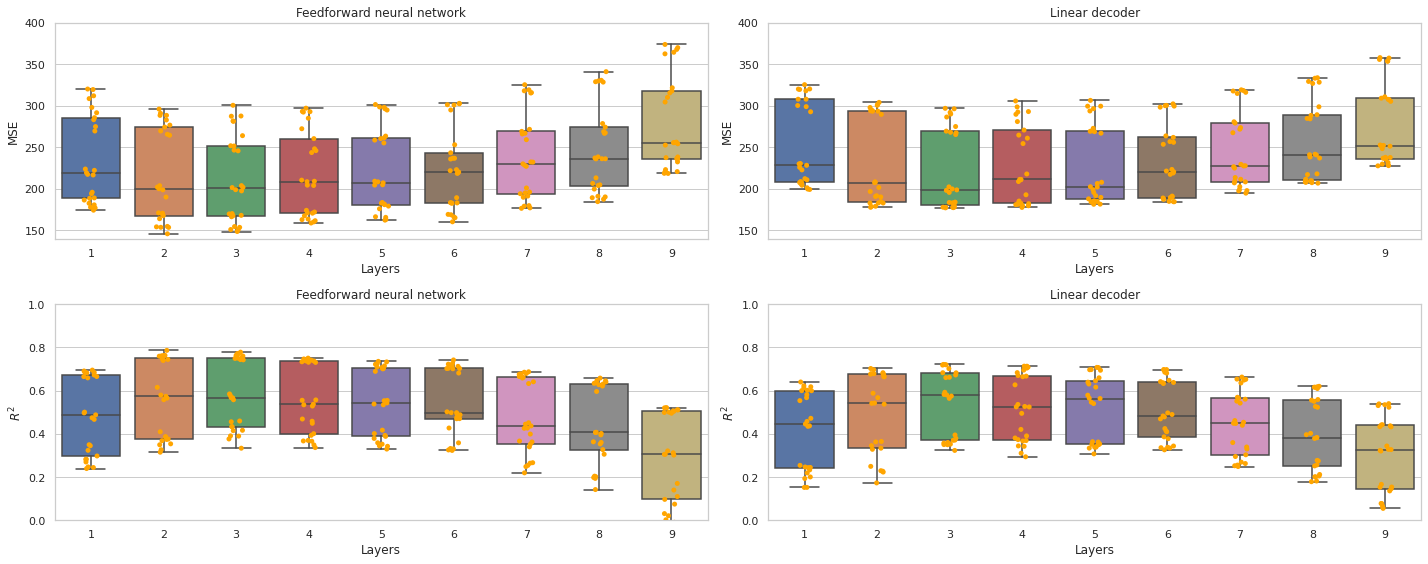

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(20,8))
pass

DATA_MSE = []
for i in range(len(MSE_models_ffnn)):
  DATA_MSE.append([x for K in MSE_models_ffnn[i] for x in K])

DATA_R2 = []
for i in range(len(R2_models_ffnn)):
  DATA_R2.append([x for K in R2_models_ffnn[i] for x in K])

DATA_MSEglm = []
for i in range(len(MSE_models_glm)):
  DATA_MSEglm.append([x for K in MSE_models_glm[i] for x in K])

DATA_R2glm = []
for i in range(len(R2_models_glm)):
  DATA_R2glm.append([x for K in R2_models_glm[i] for x in K])

plt.subplot(2,2,1)
ax = sns.boxplot(data=DATA_MSE)
ax = sns.stripplot(data=DATA_MSE,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('MSE')
plt.xlabel('Layers')
plt.title('Feedforward neural network')
plt.ylim([140,400])

plt.subplot(2,2,2)
ax = sns.boxplot(data=DATA_MSEglm)
ax = sns.stripplot(data=DATA_MSEglm,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('MSE')
plt.xlabel('Layers')
plt.title('Linear decoder')
plt.ylim([140,400])

plt.subplot(2,2,3)
ax = sns.boxplot(data=DATA_R2)
ax = sns.stripplot(data=DATA_R2,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('$R^2$')
plt.xlabel('Layers')
plt.title('Feedforward neural network')
plt.ylim([0,1])

plt.subplot(2,2,4)
ax = sns.boxplot(data=DATA_R2glm)
ax = sns.stripplot(data=DATA_R2glm,color='orange')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(list(range(1,10)))
plt.ylabel('$R^2$')
plt.xlabel('Layers')
plt.title('Linear decoder')
plt.ylim([0,1])

## Time Lag

In [ ]:
n_epochs = 100
batch_size = 15#int(len(pupArea)/2)

In [ ]:
trained_ffnn_models_timelag = []
trained_glm_models_timelag = []
MSE_models_ffnn_timelag, MSE_models_glm_timelag, MSE_models_cnn_timelag = [], [], []
R2_models_ffnn_timelag, R2_models_glm_timelag, R2_models_cnn_timelag = [], [], []
predictions_ffnn_timelag, predictions_glm_timelag, predictions_cnn_timelag = [], [], []
trials = 15
L = neurDat.shape[1]
pupArea_lag = np.zeros(np.shape(pupArea))
index = np.linspace(0,len(pupArea)-1,len(pupArea))
LAGS = 20
for lag in range(LAGS):

  predictions_ffnn_timelag.append([])
  R2_models_ffnn_timelag.append([])
  MSE_models_ffnn_timelag.append([])

  predictions_glm_timelag.append([])
  R2_models_glm_timelag.append([])
  MSE_models_glm_timelag.append([])

  tlag = int(lag-LAGS/2)

  for i in range(trials):

    k = np.roll(index,tlag)
    X_indices = [int(x) for x in k[max(0,tlag):min(len(k)+tlag,len(k))]]
    T = round(len(X_indices)*0.25)
    X_train, X_test, y_train, y_test = split_dataset(neurDat.T[X_indices],pupArea[max(0,tlag):min(len(k)+tlag,len(k))],trials,i,T)

    model_glm = linear_model.LinearRegression()
    model_glm.fit(X_train,y_train)

    y_pred_glm = model_glm.predict(X_test)
    predictions_glm_timelag[-1].append([y_pred_glm,y_test,X_test])
    R2_models_glm_timelag[-1].append(sk.metrics.r2_score(y_test,y_pred_glm))
    MSE_models_glm_timelag[-1].append(sk.metrics.mean_squared_error(y_test,y_pred_glm,squared=False))

In [ ]:
np.linspace(-10,10,21)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

Text(0, 0.5, 'MSE')

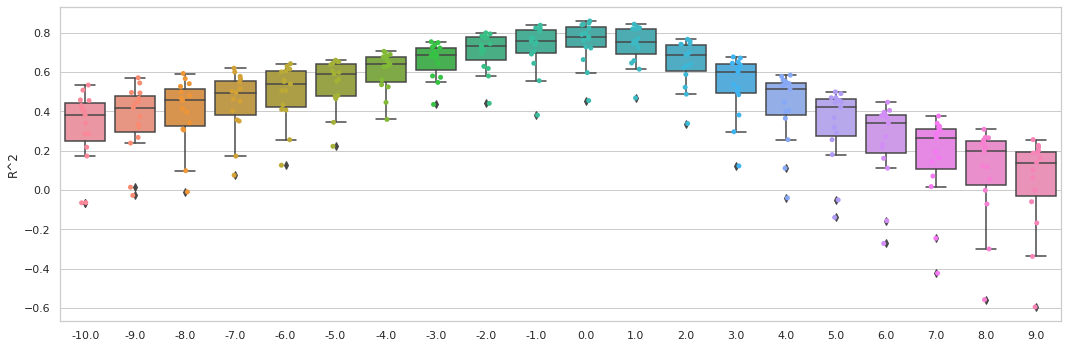

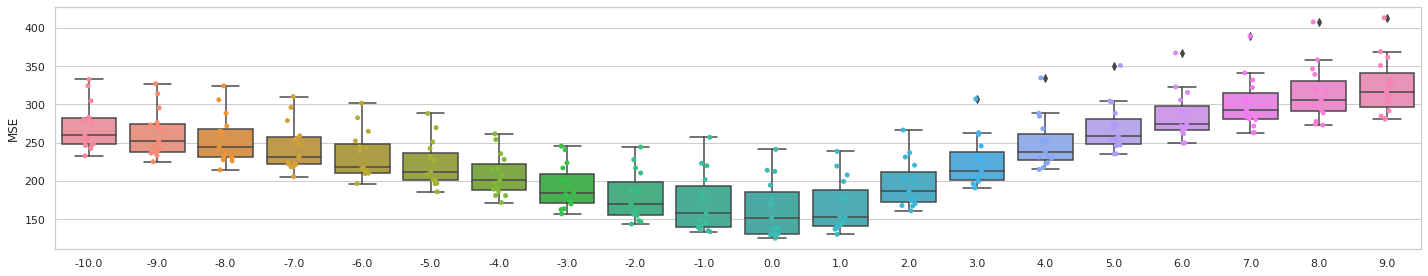

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

plt.figure(1)
ax = sns.boxplot(data=R2_models_glm_timelag)
sns.stripplot(data = R2_models_glm_timelag)
#ax = sns.stripplot(data=[[model_information[x]['accuracy'] for x in model_information if model_information[x]['layers']==k] for k in range(1,4)],color='orange')
ax.set_xticks(range(20))
ax.set_xticklabels(np.linspace(-10,9,20))
plt.ylabel('R^2')

plt.figure(2)
ax = sns.boxplot(data=MSE_models_glm_timelag)
sns.stripplot(data = MSE_models_glm_timelag)
#ax = sns.stripplot(data=[[model_information[x]['accuracy'] for x in model_information if model_information[x]['layers']==k] for k in range(1,4)],color='orange')
ax.set_xticks(range(20))
ax.set_xticklabels(np.linspace(-10,9,20))
plt.ylabel('MSE')

#### Speed

In [ ]:
trained_ffnn_models_run = []
trained_glm_models_run = []
trained_ffnn_original_models_run = []
MSE_models_ffnn_run, MSE_models_glm_run, MSE_models_ffnn_original_run = [], [], []
R2_models_ffnn_run, R2_models_glm_run, R2_models_ffnn_original_run = [], [], []
predictions_ffnn_run, predictions_glm_run, predictions_ffnn_original_run = [], [], []
T = round(len(dat['run'])*0.25)
trials = 15
L = neurDat.shape[1]
for i in range(trials):
  
  X_train, X_test, y_train, y_test = split_dataset(neurDat.T,dat['run'],trials,i,T)

  # New Model
  model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf'+str(i).zfill(len(str(trials))),activation = ['relu','tanh'])
  model = model_tf()
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
  model.fit(X_train,y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test),callbacks=[callback])
  trained_ffnn_models_run.append(model)

  y_pred = model.predict(X_test)
  predictions_ffnn_run.append([y_pred,y_test,X_test])
  R2_models_ffnn_run.append(sk.metrics.r2_score(y_test,y_pred))
  MSE_models_ffnn_run.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))

  #Original Model
  model_tf_ORIGINAL = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf'+str(i).zfill(len(str(trials))),activation = ['relu','tanh'])
  model_ORIGINAL = model_tf_ORIGINAL()
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
  model_ORIGINAL.fit(X_train,y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(X_test, y_test),callbacks=[callback])
  trained_ffnn_original_models_run.append(model)

  y_pred = model_ORIGINAL.predict(X_test)
  predictions_ffnn_original_run.append([y_pred,y_test,X_test])
  R2_models_ffnn_original_run.append(sk.metrics.r2_score(y_test,y_pred))
  MSE_models_ffnn_original_run.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))

  #GLM Model
  model_glm = linear_model.LinearRegression()
  model_glm.fit(X_train,y_train)

  y_pred_glm = model_glm.predict(X_test)
  predictions_glm_run.append([y_pred_glm,y_test,X_test])
  R2_models_glm_run.append(sk.metrics.r2_score(y_test,y_pred_glm))
  MSE_models_glm_run.append(sk.metrics.mean_squared_error(y_test,y_pred_glm,squared=False))

Epoch 1/100
351/351 [==============================] - 3s 8ms/step - loss: 25.7927 - val_loss: 21.7267
Epoch 2/100
351/351 [==============================] - 1s 3ms/step - loss: 7.9909 - val_loss: 13.8636
Epoch 3/100
351/351 [==============================] - 1s 3ms/step - loss: 4.2609 - val_loss: 12.0917
Epoch 4/100
351/351 [==============================] - 1s 3ms/step - loss: 2.7680 - val_loss: 12.5658
Epoch 5/100
351/351 [==============================] - 1s 3ms/step - loss: 2.1910 - val_loss: 12.4026
Epoch 6/100
351/351 [==============================] - 1s 3ms/step - loss: 1.7778 - val_loss: 12.8752
Epoch 7/100
351/351 [==============================] - 1s 3ms/step - loss: 1.5643 - val_loss: 12.0643
Epoch 8/100
351/351 [==============================] - 1s 3ms/step - loss: 1.3072 - val_loss: 13.0163
Epoch 9/100
351/351 [==============================] - 1s 3ms/step - loss: 1.1088 - val_loss: 11.7166
Epoch 10/100
351/351 [==============================] - 1s 3ms/step - loss: 0.997

Text(0, 0.5, 'MSE')

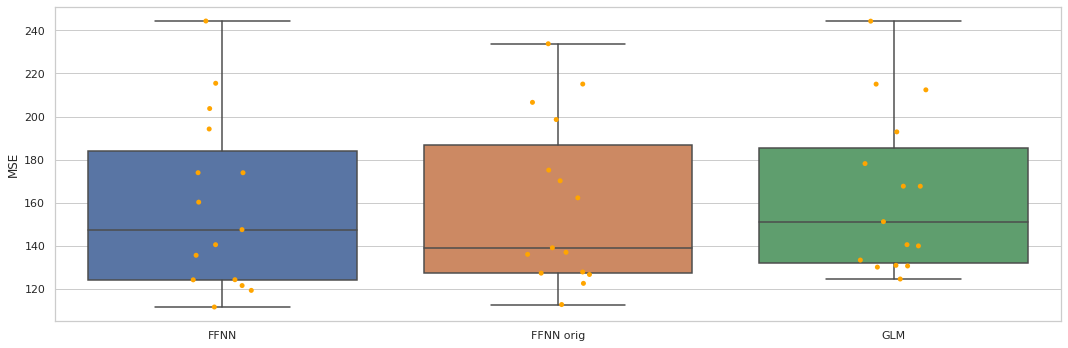

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

ax = sns.boxplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm])
ax = sns.stripplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm],color='orange')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['FFNN','FFNN orig','GLM'])#, minor=False, rotation=45)
# plt.title('MSE')
plt.ylabel('MSE')

In [ ]:
print([MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm])

[[215.42219458348973, 194.21190692588848, 173.9282592180641, 140.5295879037159, 121.56833922180817, 119.32822963034168, 111.61586160020524, 160.2733427035106, 244.30254690221926, 203.6919467347749, 147.51031875410953, 124.27931813134656, 124.22524084905143, 135.6117090516331, 173.9098013101488], [215.05873388118897, 198.59171602137852, 170.17579619343635, 136.99485707612848, 126.70844055626324, 122.58673518496211, 112.75150427983102, 162.25948102927669, 233.7482499672927, 206.56955713535325, 139.09047806139188, 127.85992509141052, 127.31976114330583, 136.0539178445888, 175.1367117527349], [212.37339754691283, 192.87092534402797, 167.67572045121796, 139.96498503995193, 130.94684536855578, 130.1184778633433, 124.60314001861818, 178.1521346412587, 244.23933970976623, 215.02610391372986, 151.22241224749973, 130.6487780094949, 133.39558511683433, 140.53413585016924, 167.65240333034242]]


Text(0, 0.5, '$R^2$')

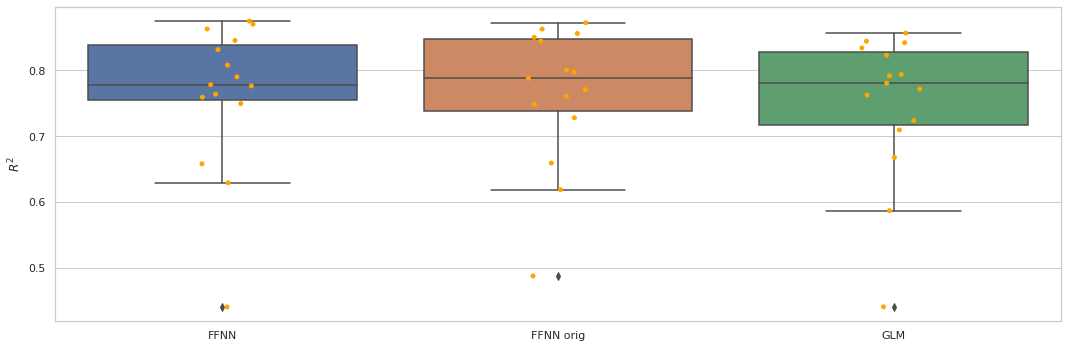

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

ax = sns.boxplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm])
ax = sns.stripplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm],color='orange')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['FFNN','FFNN orig','GLM'])#, minor=False, rotation=45)
# plt.title('MSE')
plt.ylabel('$R^2$')

In [ ]:
print([R2_models_ffnn,R2_models_ffnn_original,R2_models_glm])

[[0.6579379989297456, 0.7593018093470691, 0.7783481173769217, 0.7901421935743325, 0.7496107721416152, 0.8080335911402113, 0.8751817018593884, 0.7764884025785241, 0.4400261705731888, 0.6291004008208785, 0.8316454026467334, 0.8704155097910551, 0.863119547247278, 0.8456338234789345, 0.7639070780981568], [0.6590912804082611, 0.7483230873878557, 0.787809123778709, 0.8005665001151352, 0.7279894395072275, 0.7974063619712499, 0.8726288370324399, 0.7709144806228695, 0.487364736392328, 0.6185467818955817, 0.8503161389613682, 0.8628410372163632, 0.856215070584871, 0.844625453669126, 0.760564119361847], [0.6675516589440477, 0.7626142479989821, 0.7939979767160193, 0.7918250889733801, 0.7094875465436983, 0.7717468423997227, 0.84444484849516, 0.7238407886120489, 0.44031589162070284, 0.5866756245486286, 0.8230655092365766, 0.8567924202916014, 0.8421645143737975, 0.8342240887282171, 0.7805910110147387]]


#### Add CNN data

In [ ]:
MSE_CNN_new = [263.35306737105856, 230.63909157682693, 197.98136160450437, 174.40937184725763, 147.0335751319743, 138.65793008301878, 202.23695908413933, 270.3312140174709, 234.65447964026063, 220.71208036011248, 173.3309150592962, 139.14233786594795, 146.5957911704394, 170.1009005830357, 195.86312861966158]
MSE_CNN_original = [228.45936672499178, 221.2403905960185, 231.48376647153978, 170.8813252684118, 124.41767177070537, 137.86717248740183, 164.51682238951338, 183.6824314257648, 180.69669703675163, 181.54615842989344, 164.14680067147475, 179.42912505617136, 169.44513993196622, 255.44759034534337]

R2_CNN_new = [0.48878839700048526, 0.6605412886258006, 0.7128031069521685, 0.6767569325042875, 0.7085447516450449, 0.8073735814467567, 0.6441241432291025, 0.3143473941487954, 0.5077719652592136, 0.5645273793944257, 0.7675485620864484, 0.8375671392548965, 0.8093816343722451, 0.7571316094810706, 0.7005390320031117]
R2_CNN_original = [0.6152825570649658, 0.6876439273353727, 0.6073801940250136, 0.6897021327111064, 0.7377359196782802, 0.8095643896527875, 0.7644961029638796, 0.6834466014626308, 0.7081168163534146, 0.7449917067587484, 0.7739418621093535, 0.7144332644307999, 0.7590005771671371, 0.490624010360304]

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

ax = sns.boxplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm,MSE_CNN_new,MSE_CNN_original])
ax = sns.stripplot(data=[MSE_models_ffnn,MSE_models_ffnn_original,MSE_models_glm,MSE_CNN_new,MSE_CNN_original],color='orange')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['FFNN','FFNN orig','GLM'])#, minor=False, rotation=45)
# plt.title('MSE')
plt.ylabel('MSE')

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
pass

ax = sns.boxplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm,R2_CNN_new])
ax = sns.stripplot(data=[R2_models_ffnn,R2_models_ffnn_original,R2_models_glm,R2_CNN_new],color='orange')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['FFNN','FFNN orig','GLM'])#, minor=False, rotation=45)
# plt.title('MSE')
plt.ylabel('$R^2$')